## Credit Risk Modelling - Probability of Default

This notebook uses behavioral and application data to create and compare probability of default models uisng Logistic Regression and XG Boost. 

1. Data Preperation
2. Initial Analysis
3. One Hot Encoding
4. Logistic Regression
5. XG Boost
6. Initial Comparison Logistic Regression with XGBoost
7. Feature Selection
9. Class Imbalance

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import xgboost as xgb

### 1. Data Preperation


In [2]:
# load and print first 5 rows
df = pd.read_csv('cr_loan2.xls')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
# Create the cross table for loan status, home ownership, and the max employment length
pd.crosstab(df['loan_status'],df['person_home_ownership'],
                  values=df['person_emp_length'], aggfunc='max')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,123.0,24.0,31.0,41.0
1,34.0,11.0,17.0,123.0


In [4]:
# Removing outliers where employment length is greater than 60
indices = df[df['person_emp_length'] > 60].index
df = df.drop(indices)

In [5]:
# Replacing missing data.
# We could alternatively use machine learning to predict a persons emplyment length and interest rate.
# For simplicity we will use median.
pd.isnull(df).sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [6]:
df['person_emp_length'].fillna((df['person_emp_length'].median()), inplace=True)

In [7]:
# We can't use these rows for training or testing the model.
indices = df[df['loan_int_rate'].isnull()].index
df = df.drop(indices)

### 2. Initial Analysis

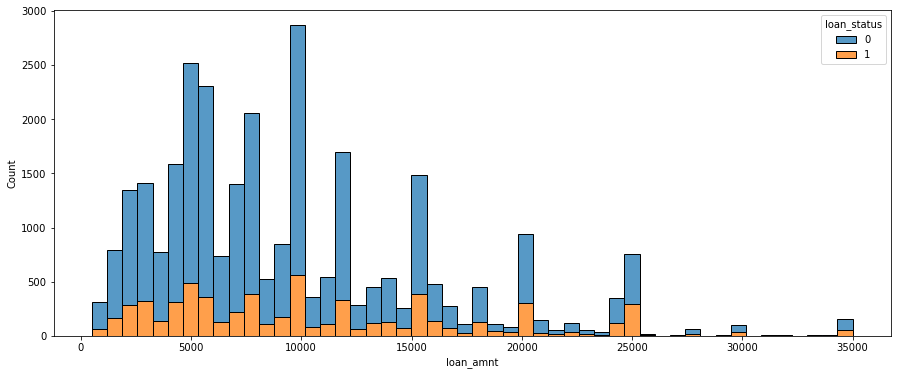

In [8]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(df, x="loan_amnt", hue="loan_status", multiple="stack", bins=50, ax=ax)

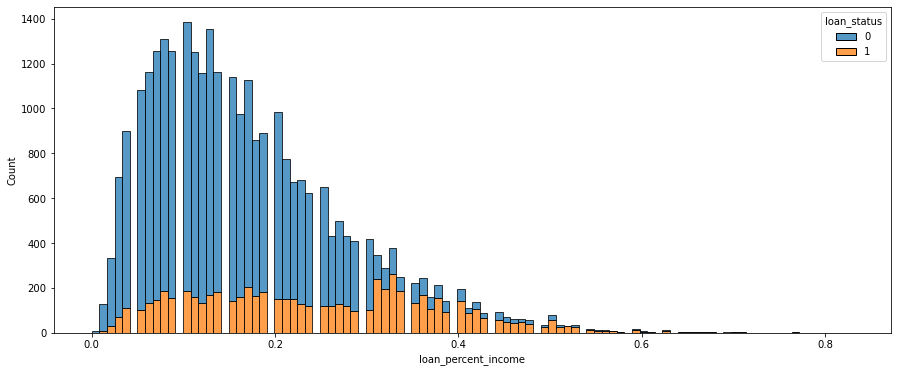

In [9]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(df, x="loan_percent_income", hue="loan_status", multiple="stack", bins=100, ax=ax)

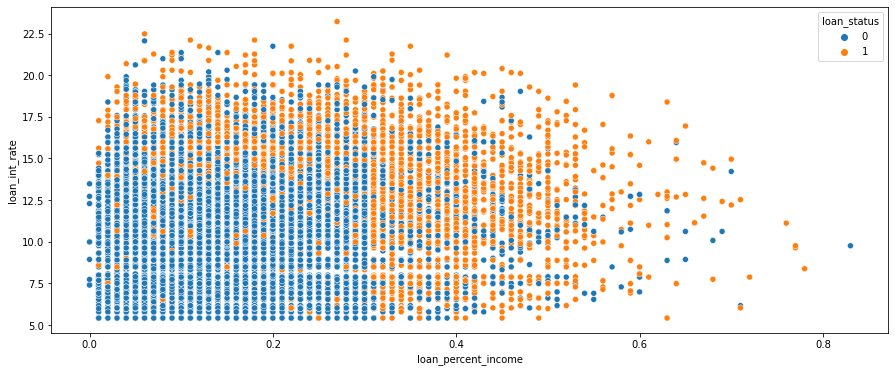

In [10]:
f, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(
    data=df,
    x="loan_percent_income", y="loan_int_rate",
    hue="loan_status",
     ax=ax,
)

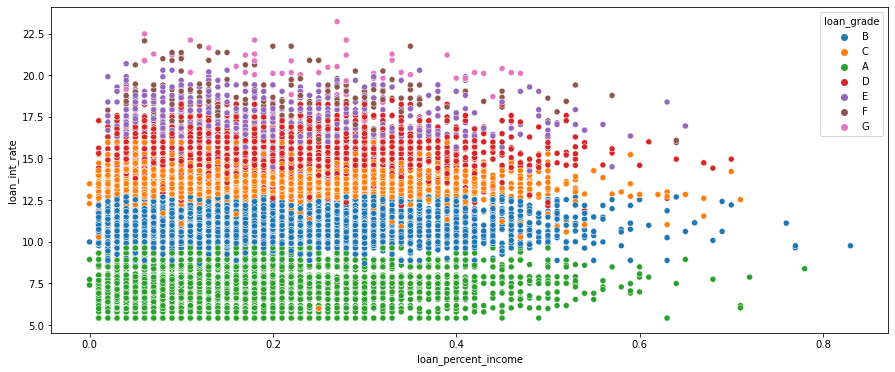

In [11]:
f, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(
    data=df,
    x="loan_percent_income", y="loan_int_rate",
    hue="loan_grade",
     ax=ax,
)

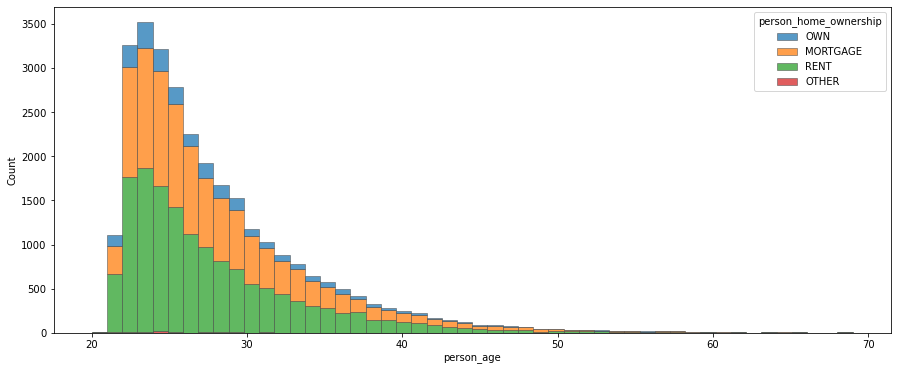

In [12]:
rage_df = df[df['person_age'] < 70]

f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(rage_df, x="person_age", hue="person_home_ownership", multiple="stack", bins=50, ax=ax,     edgecolor=".3",
    linewidth=.5)

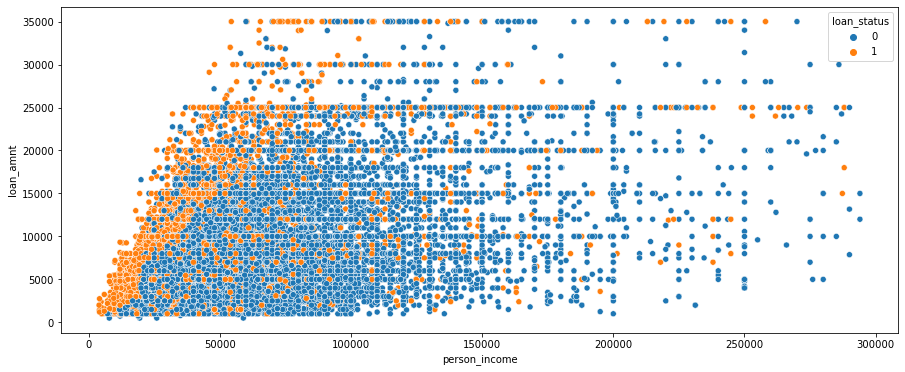

In [13]:
rincome_df = df[df['person_income'] < 300000]

f, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(
    data=rincome_df,
    x="person_income", y="loan_amnt",
    hue="loan_status",
     ax=ax,
)

In [14]:
pd.crosstab(df['loan_grade'], df['loan_status'])

loan_status,0,1
loan_grade,,
A,8796,977
B,7867,1528
C,4619,1209
D,1343,1970
E,310,571
F,64,150
G,1,58


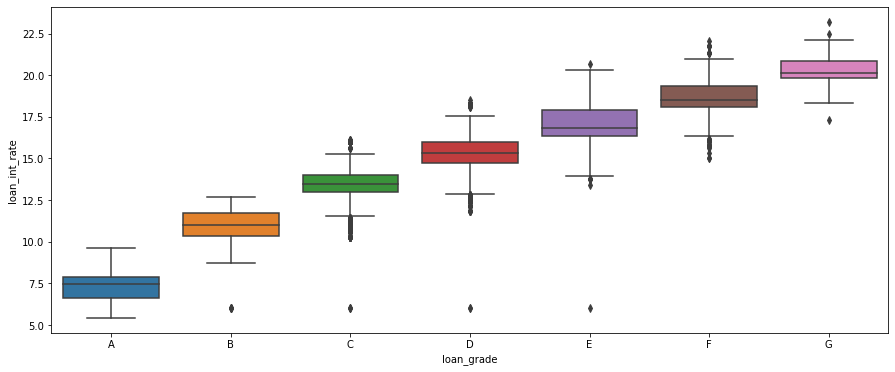

In [15]:
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="loan_grade", y="loan_int_rate", data=df,ax=ax, order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

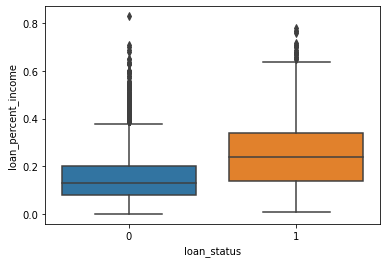

In [16]:
sns.boxplot(x="loan_status", y="loan_percent_income", data=df)

### 3. One Hot Encoding

In [17]:
# Create two data sets for numeric and non-numeric data
df_num = df.select_dtypes(exclude=['object'])
df_str = df.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
df_str_onehot = pd.get_dummies(df_str)

In [18]:
df_str_onehot.head()

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
5,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0


In [19]:
# Union the one-hot encoded columns to the numeric ones
df = pd.concat([df_num, df_str_onehot], axis=1)

# Print the columns in the new data set
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


### 4. Logistic Regression

In [20]:
# Create the X and y data sets
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

In [21]:
# Create and train a logistic regression
lr_model = LogisticRegression().fit(X_train, np.ravel(y_train))

In [22]:
# Create predictions of probability for loan status using test data
preds = lr_model.predict_proba(X_test)

# Create dataframes of predictions
lr_preds_df = pd.DataFrame(preds[:,1], columns = ['lr_prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
lr_portfolio = pd.concat([true_df.reset_index(drop = True), lr_preds_df, X_test['loan_amnt'].reset_index(drop = True)], axis = 1)
lr_portfolio['loss_given_default'] = 0.2
lr_portfolio.head()

,loan_status,lr_prob_default,loan_amnt,loss_given_default
0,0,0.132261,9000,0.2
1,0,0.061550,4000,0.2
2,0,0.131911,6300,0.2
3,0,0.456479,12400,0.2
4,0,0.377453,7500,0.2


### 5. XGBoost

In [23]:
# Create and train a XG Boost model
xgb_model = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
preds = xgb_model.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
xgb_preds_df = pd.DataFrame(preds[:,1], columns = ['xgb_prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
xgb_portfolio = pd.concat([true_df.reset_index(drop = True), xgb_preds_df, X_test['loan_amnt'].reset_index(drop = True)], axis = 1)
xgb_portfolio['loss_given_default'] = 0.2
xgb_portfolio.head()

,loan_status,xgb_prob_default,loan_amnt,loss_given_default
0,0,0.066690,9000,0.2
1,0,0.089287,4000,0.2
2,0,0.002659,6300,0.2
3,0,0.067429,12400,0.2
4,0,0.489509,7500,0.2


### 6. Initial Comparison Logistic Regression with XGBoost

In [24]:
# Create expected loss columns for each model using the formula
xgb_portfolio['xgb_expected_loss'] = xgb_portfolio['xgb_prob_default'] * xgb_portfolio['loss_given_default'] * xgb_portfolio['loan_amnt']
lr_portfolio['lr_expected_loss'] = lr_portfolio['lr_prob_default'] * lr_portfolio['loss_given_default'] * lr_portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(lr_portfolio['lr_expected_loss']))
print(accuracy_score(y_test, lr_model.predict(X_test)))

# Print the sum of the expected loss for gbt
print('XGB expected loss: ', np.sum(xgb_portfolio['xgb_expected_loss']))
print(accuracy_score(y_test, xgb_model.predict(X_test)))

LR expected loss:  2757835.7167624542
0.7977261157305278
XGB expected loss:  2682744.4593587746
0.9268623790938402


In [25]:
# Create expected loss columns for each model using the formula
xgb_portfolio['xgb_expected_loss'] = xgb_portfolio['loan_status'] * xgb_portfolio['loss_given_default'] * xgb_portfolio['loan_amnt']
lr_portfolio['lr_expected_loss'] = lr_portfolio['loan_status'] * lr_portfolio['loss_given_default'] * lr_portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR loss: ', np.sum(lr_portfolio['lr_expected_loss']))
print(accuracy_score(y_test, lr_model.predict(X_test)))

# Print the sum of the expected loss for gbt
print('XGB loss: ', np.sum(xgb_portfolio['xgb_expected_loss']))
print(accuracy_score(y_test, xgb_model.predict(X_test)))

LR loss:  2836410.0
0.7977261157305278
XGB loss:  2836410.0
0.9268623790938402


Precision – Accuracy of positive predictions. Precision = TP/(TP + FP)

Recall: Fraction of positives that were correctly identified. Recall = TP/(TP+FN)

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [26]:
# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, lr_model.predict(X_test), target_names=target_names))
print(classification_report(y_test, xgb_model.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.80      0.98      0.88      4559
     Default       0.75      0.16      0.26      1334

    accuracy                           0.80      5893
   macro avg       0.77      0.57      0.57      5893
weighted avg       0.79      0.80      0.74      5893

              precision    recall  f1-score   support

 Non-Default       0.92      0.99      0.95      4559
     Default       0.96      0.71      0.81      1334

    accuracy                           0.93      5893
   macro avg       0.94      0.85      0.88      5893
weighted avg       0.93      0.93      0.92      5893



In [27]:
# Print the confusion matrix for both old and new models
print("Logistic Regression")
print(confusion_matrix(y_test,lr_model.predict(X_test)))
print("XG Boost")
print(confusion_matrix(y_test,xgb_model.predict(X_test)))

Logistic Regression
[[4487   72]
 [1120  214]]
XG Boost
[[4521   38]
 [ 393  941]]


In [28]:
# Print and compare the AUC scores of the old and new models
print("Logistic Regression")
print(roc_auc_score(y_test, lr_model.predict(X_test)))
print("XG Boost")
print(roc_auc_score(y_test, xgb_model.predict(X_test)))

Logistic Regression
0.5723134265286747
XG Boost
0.8485310700648798


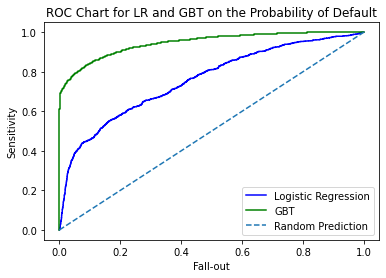

In [29]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, lr_model.predict_proba(X_test)[:,1])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [30]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1]))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))

Logistic Regression AUC Score: 0.76
Gradient Boosted Tree AUC Score: 0.95


### 7. Feature selection
We can look into selecting and exlcuding certain features to improve the model.

In [31]:
# Logistic Regression Features
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(lr_model.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
3,loan_int_rate,1.062004e-04
4,loan_percent_income,9.206094e-08
20,loan_grade_E,1.097259e-08
10,loan_intent_DEBTCONSOLIDATION,8.131773e-09
21,loan_grade_F,3.427977e-09
5,cb_person_cred_hist_length,2.567566e-09
11,loan_intent_EDUCATION,2.525402e-09
13,loan_intent_MEDICAL,1.792888e-09
14,loan_intent_PERSONAL,1.335184e-09
22,loan_grade_G,9.933307e-10


In [32]:
# Print the column importances from the model
xgb_model.get_booster().get_score(importance_type = 'weight')

{'loan_percent_income': 266,
 'loan_int_rate': 516,
 'person_income': 837,
 'loan_intent_HOMEIMPROVEMENT': 49,
 'loan_amnt': 317,
 'loan_grade_D': 44,
 'loan_grade_C': 46,
 'loan_intent_DEBTCONSOLIDATION': 56,
 'loan_intent_MEDICAL': 75,
 'person_home_ownership_OWN': 45,
 'person_emp_length': 281,
 'person_home_ownership_RENT': 63,
 'person_age': 274,
 'person_home_ownership_OTHER': 2,
 'person_home_ownership_MORTGAGE': 58,
 'loan_intent_VENTURE': 31,
 'loan_intent_EDUCATION': 33,
 'loan_grade_E': 30,
 'loan_grade_F': 18,
 'loan_grade_G': 13,
 'cb_person_cred_hist_length': 168,
 'loan_grade_B': 25,
 'cb_person_default_on_file_N': 23,
 'loan_intent_PERSONAL': 28,
 'loan_grade_A': 2}

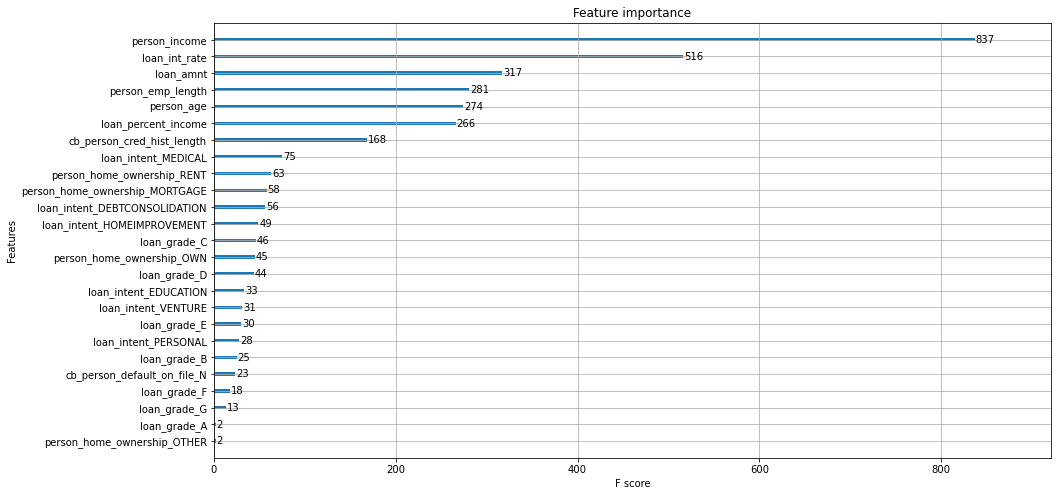

In [33]:
# Plot the column importance for this model
f, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(xgb_model, importance_type = 'weight', ax=ax)
plt.show()

### 8. Class imbalance
We can look into balancing the training data for higher predictive accuracy.

In [34]:
y_train.value_counts()

0    18441
1     5129
Name: loan_status, dtype: int64

Undersamping

In [35]:
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

In [36]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

1    5129
0    5129
Name: loan_status, dtype: int64
